## Toxic Comment Classification Using Deep Learning

Study of negative online behaviour. We need to be able to classify text and discern between different levels of toxicity and disrespectful behaviour - such as like threats, obscenity, insults, and identity-based hate etc

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

raw_data = pd.read_csv('../data/train.csv', encoding="utf-8")
display(raw_data.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Word2Vec

Vectorize the text

In [2]:
import nltk
import sklearn
import gensim
from nltk import word_tokenize, sent_tokenize
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import matplotlib.pyplot as plt                        
%matplotlib inline

class vectorizer(object):
    def __init__(self, vector_method, size, sg, window, min_count, seed, workers, sents):
        self._vector_method = vector_method
        self._size = size
        self._sg = sg
        self._window = window
        self._min_count = min_count
        self._seed = seed
        self._sents = sents
        self._workers = workers
        
    def vectorize_model(self):
        model = self._vector_method(sentences=self._sents, size=self._size, sg=self._sg,
                 window=self._window, min_count=self._min_count, seed=self._seed,
                 workers=self._workers)
        
        return model
        

In [3]:
# print(raw_data['comment_text'][:2])
def parse_sentences():
    sentences = []
    for index, row in raw_data.iterrows():
        text = row['comment_text']
        sent = list(sent_tokenize(text.lower()))
        sentences.append(sent)

    return sentences

def word_process(some_text):
    stop_words = set(stopwords.words('english'))    
    words = word_tokenize(some_text[0].lower())
    
    filtered_words = []
    for w in words:
        if w not in stop_words:
            filtered_words.append(w)
            
    return list(words) 

def parse_raw():
    documents = []
    sents = parse_sentences()
    for sent in sents:
        processed = word_process(sent)
        documents.append(processed)
    
    return documents

sentences = parse_raw()
# print(sentences)

word2vec_method = vectorizer(Word2Vec, 64, 1, 10, 3, 42, 2, sentences)
word2vec_model = word2vec_method.vectorize_model()
print('done processing')


done processing


In [4]:
# print(word2vec_model.wv.vocab)
# print(word2vec_model['fuck'])
print(word2vec_model.most_similar('fuck'))

[('vuvuzelas', 0.824993371963501), ('f***', 0.8162283301353455), ('shyt', 0.8046882152557373), ('turd', 0.8025966882705688), ('cocksucker', 0.799262285232544), ('suppressing', 0.7980784177780151), ('niggertard', 0.7910893559455872), ('dianna', 0.790585458278656), ('fascists', 0.7872260808944702), ('fucky', 0.7856225967407227)]


/usr/lib/python3.4/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/lib/python3.4/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


          x         y           token
0  1.754921  0.163467          runoff
1  2.798571  1.484710        fabregas
2 -1.044689  0.191600  unsatisfactory
3  3.720585 -1.126828       android79
4 -1.800121 -1.825805      deprecated


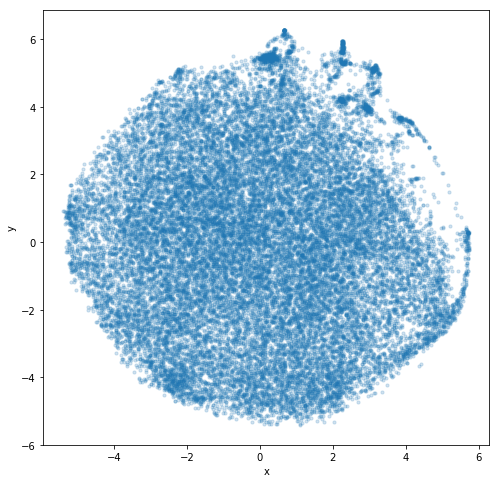

In [5]:
tsne = TSNE(n_components=2, n_iter=300)

X = word2vec_model[word2vec_model.wv.vocab]
X_2d = tsne.fit_transform(X)
coords_df = pd.DataFrame(X_2d, columns=['x', 'y'])
coords_df['token'] = word2vec_model.wv.vocab.keys()

print(coords_df.head())

# Plot the graph.
coords_df.plot.scatter('x', 'y', figsize=(8,8),
                       marker='o', s=10, alpha=0.2)

We define the features and labels

In [4]:
# clean up the docs and labels a bit
all_docs = list(raw_data['comment_text'])
all_labels = np.array(list(raw_data['toxic']))

def retrieve_toxic_data():
    toxic_docs = []
    toxic_labels = []
    for index, row in raw_data.iterrows():
        if int(row['toxic']) == 1:
            toxic_docs.append(row['comment_text'])
            toxic_labels.append(raw_data.iloc[index,2:])
            
    return toxic_docs, np.array(toxic_labels), len(toxic_docs)

toxic_docs, toxic_labels, toxic_entries = retrieve_toxic_data()    

print(toxic_docs[:2])
print(toxic_labels[:6])
print(toxic_entries)

['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK', 'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...']
[[1 1 1 0 1 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 1 0 1 1]
 [1 0 1 0 1 0]
 [1 0 0 0 0 0]]
15294


### Feed-forward neural network

In [4]:
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

class neural_network(object):
    def __init__(self, docs, labels, epochs, batch_size, dropout):
        self._model = Sequential()
        self._docs = docs
        self._labels = labels
        self._epochs = epochs
        self._batch_size = batch_size
        self._dropout = dropout
     
    def split_data(self, docs, targets):
        length = len(docs)
        split_point = int(round(length * 0.8))
        return docs[:split_point], targets[:split_point], docs[split_point:], targets[split_point:]
        
    def prepare_docs(self, max_length):
        t = Tokenizer(num_words=5000)
        t.fit_on_texts(self._docs)
        vocab_size = len(t.word_index) + 1
        encoded_docs = t.texts_to_sequences(self._docs)
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
        return padded_docs, t
    
    # only put in top 5000 words?
    def calc_embedding_matrix(self, vocab_size, t):
        embedding_matrix = np.zeros((vocab_size, 64))
        for word, i in t.word_index.items():
            if word in word2vec_model.wv.vocab:
                embedding_vector = word2vec_model.wv[word]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                
        return embedding_matrix
    
    def construct_model(self, vocab_size, max_length, embedding_matrix):
        
        embedding_layer = Embedding(vocab_size, 64, weights=[embedding_matrix], input_length=max_length)
        embedding_layer.trainable = False
        
        self._model.add(embedding_layer)
        self._model.add(Flatten())
        self._model.add(Dense(64, activation='relu'))
        self._model.add(Dense(64, activation='relu'))
        self._model.add(Dropout(self._dropout))
        self._model.add(Dense(1, activation='sigmoid'))
        self._model.summary()
        
    def compile_model(self):
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self._model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.feed_forward_network.hdf5', 
                               verbose=1, save_best_only=True)
        
        return checkpointer
        
    def train_save_model(self, train_docs, train_targets, valid_docs, valid_targets, checkpointer):
        trained_model = self._model.fit(train_docs, train_targets, validation_data=(valid_docs, valid_targets), 
                          epochs=self._epochs, batch_size=self._batch_size, callbacks=[checkpointer], verbose=1)

        with open('pickles/feed_forward_network', 'wb') as file_pi:
            pickle.dump(trained_model.history, file_pi)
            
        return trained_model
            
    def get_model(self):
        return self._model

Using TensorFlow backend.


In [6]:
feed_forward_network = neural_network(all_docs, all_labels, 8, 32, 0.5)
padded_docs, t = feed_forward_network.prepare_docs(150)
print(padded_docs[:2])

[[ 688   75    1  126  130  177   29  672 4530 1117   86  331   51 2278
    50   15   60 2760  148    7 2942   34  117 1221 2831    4   45   59
   244    1  365   31    1   38   27  143   73 3473   89 3087 4592 2275
   985    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [  52 2639   13  556 3812   73 4578 2708   21   94   38  804 2682  992
   589  182    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0

In [7]:
embedding_matrix = feed_forward_network.calc_embedding_matrix(len(t.word_index) + 1, t)
# print(embedding_matrix)

In [8]:
train_valid_docs, train_valid_targets, test_docs, test_targets = feed_forward_network.split_data(padded_docs, all_labels)
train_docs, train_targets, valid_docs, valid_targets = feed_forward_network.split_data(train_valid_docs, train_valid_targets)

In [9]:
feed_forward_network.construct_model(len(t.word_index) + 1, 150, embedding_matrix)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 64)           13461632  
_________________________________________________________________
flatten_1 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                614464    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,080,321.0
Trainable params: 618,689.0
Non-trainable params: 13,461,632.0
____________________________________________________

In [10]:
checkpointer = feed_forward_network.compile_model()

In [11]:
trained_feed_forward_model = feed_forward_network.train_save_model(train_docs, train_targets, valid_docs, valid_targets, checkpointer)

Train on 102126 samples, validate on 25531 samples
Epoch 1/8
102126/102126 [==============================] - 19s - loss: 0.1692 - acc: 0.9412 - val_loss: 0.1514 - val_acc: 0.9461
Epoch 2/8
102126/102126 [==============================] - 18s - loss: 0.1397 - acc: 0.9491 - val_loss: 0.1509 - val_acc: 0.9462
Epoch 3/8
102126/102126 [==============================] - 18s - loss: 0.1290 - acc: 0.9526 - val_loss: 0.1539 - val_acc: 0.9461
Epoch 4/8
102126/102126 [==============================] - 18s - loss: 0.1187 - acc: 0.9558 - val_loss: 0.1543 - val_acc: 0.9452
Epoch 5/8
102126/102126 [==============================] - 18s - loss: 0.1087 - acc: 0.9596 - val_loss: 0.1713 - val_acc: 0.9458
Epoch 6/8
102126/102126 [==============================] - 18s - loss: 0.0994 - acc: 0.9626 - val_loss: 0.1909 - val_acc: 0.9376
Epoch 7/8
102126/102126 [==============================] - 18s - loss: 0.0883 - acc: 0.9675 - val_loss: 0.1829 - val_acc: 0.9438
Epoch 8/8
102126/102126 [=====================

### Get the predictions and evaluate the accuracy

In [5]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

# test_docs, test_targets

class predictive_evaluate(object):
    def __init__(self, test_docs, test_targets, model):
        self._test_docs = test_docs
        self._test_targets = test_targets
        self._model = model
        
    def get_predictions(self):
        predictions = []
        for doc in self._test_docs:
            result = self._model.predict(np.expand_dims(doc, axis=0))
            preds = result[0][0]
            predictions.append(1 if preds >= 0.5 else 0)
                    
        return predictions
    
    def get_multilabel_predictions(self):
        predictions = []
        for doc in self._test_docs:
            result = self._model.predict(np.expand_dims(doc, axis=0))
            preds = result[0]
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0 
            predictions.append(preds)
                    
        return predictions
        
    def get_metrics(self, predictions):
        # print(self._test_targets[0])
        # print(predictions[0])
        model_recall_score = recall_score(self._test_targets, predictions, average='weighted')
        model_precision_score = precision_score(self._test_targets, predictions, average='weighted')
        model_f1_score = f1_score(self._test_targets, predictions, average='weighted')
        
        return model_recall_score, model_precision_score, model_f1_score
        

In [13]:
model = feed_forward_network.get_model()
model.load_weights('saved_models/weights.feed_forward_network.hdf5')

evaluation = predictive_evaluate(test_docs, test_targets, model)
predictions = np.array(evaluation.get_predictions()).astype(int)

print(predictions[100:110])

[0 1 0 0 0 0 1 0 0 0]


In [14]:
model_recall_score = recall_score(np.array(test_targets), predictions, average='weighted')
model_precision_score = precision_score(np.array(test_targets), predictions, average='weighted')
model_fbeta_score = fbeta_score(np.array(test_targets), predictions, average='weighted', beta=1)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)
print('F-beta score:', model_fbeta_score)

Recall score: 0.9479538760418625
Precision score: 0.9445922435280035
F-beta score: 0.942619594779


### Try a convolutional neural network

In [6]:
from keras.layers import Conv1D, SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D
from keras.optimizers import SGD

class cnn_neural_network(neural_network):
    def __init__(self, docs, labels, epochs, batch_size, dropout, pad, drop_embed, n_conv, k_conv):
        super(cnn_neural_network, self).__init__(docs, labels, epochs, batch_size, dropout)
        self._pad = pad
        self._drop_embed = drop_embed
        self._n_conv = n_conv
        self._k_conv = k_conv
        
    def prepare_docs(self, max_length):
        t = Tokenizer(num_words=5000)
        t.fit_on_texts(self._docs)
        vocab_size = len(t.word_index) + 1
        encoded_docs = t.texts_to_sequences(self._docs)
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding=self._pad, truncating=self._pad, value=0)
        return padded_docs, t
    
    def construct_model(self, vocab_size, max_length, embedding_matrix):
        
        embedding_layer = Embedding(vocab_size, 64, weights=[embedding_matrix], input_length=max_length)
        embedding_layer.trainable = False
        
        self._model.add(embedding_layer)
        self._model.add(SpatialDropout1D(self._drop_embed))
        self._model.add(Conv1D(self._n_conv, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 2, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 4, self._k_conv, activation='relu'))
        self._model.add(GlobalMaxPool1D())
        self._model.add(Dense(self._n_conv, activation='relu'))
        self._model.add(Dropout(self._dropout))
        self._model.add(Dense(1, activation='sigmoid'))
        self._model.summary()
        
    def construct_toxic_model(self, vocab_size, max_length, embedding_matrix):
        
        embedding_layer = Embedding(vocab_size, 64, weights=[embedding_matrix], input_length=max_length)
        embedding_layer.trainable = False
        
        self._model.add(embedding_layer)
        self._model.add(SpatialDropout1D(self._drop_embed))
        self._model.add(Conv1D(self._n_conv, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 2, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 4, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 8, self._k_conv, activation='relu'))
        self._model.add(GlobalMaxPool1D())
        self._model.add(Dropout(self._dropout))
        self._model.add(Dense(6, activation='sigmoid'))
        self._model.summary()
        
    def compile_model(self, model_name):
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self._model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
        checkpointer = ModelCheckpoint(filepath='saved_models/' + model_name, 
                               verbose=1, save_best_only=True)
        
        return checkpointer
        
    def train_save_model(self, train_docs, train_targets, valid_docs, valid_targets, checkpointer, model_name):
        trained_model = self._model.fit(train_docs, train_targets, validation_data=(valid_docs, valid_targets), 
                          epochs=self._epochs, batch_size=self._batch_size, callbacks=[checkpointer], verbose=1)

        with open('pickles/cnn_network' + model_name, 'wb') as file_pi:
            pickle.dump(trained_model.history, file_pi)
            
        return trained_model
            
    def get_model(self):
        return self._model
    

In [54]:
# downsampling
def downsample(docs, labels):
    downsample_index = 0
    for index, label in enumerate(labels):
        if int(label) == 1 and int(labels[index + 1]) == 0:
            del docs[index + 1]
            del labels[index + 1]
            
    return docs, np.array(labels) , len(docs)

def filter_df(filter_limit, raw_df):
    dataframe = raw_df.copy()
    dataframe = dataframe.sort_values('toxic', ascending=True)
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.iloc[filter_limit:]

    return dataframe.sample(frac=1).reset_index(drop=True)
        
dataframe = filter_df(95000, raw_data)
display(dataframe.head())
display(dataframe.describe())

shrink_docs = list(dataframe['comment_text'])
shrink_labels = np.array(list(dataframe['toxic']))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,7d457ec30f201bc6,"""\n\nI don't think you were hasty at all. Hav...",0,0,0,0,0,0
1,82c887484657c1ee,MY USER PAGE \nОМFG STOP FREAKING DELETING MY ...,1,0,1,0,1,0
2,5a3b9c9f5b76daec,Come on fag boy. Block me.,1,0,0,0,1,0
3,c5ca89f33b12096c,The link you added to English Cuisine is consi...,0,0,0,0,0,0
4,76e84ba028dbcae3,"""\n\nI do not intend to embark on the Ritz the...",0,0,0,0,0,0


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,64571.000000,64571.000000,64571.000000,64571.000000,64571.000000,64571.000000
mean,0.236856,0.024701,0.125459,0.007124,0.116523,0.020675
std,0.425156,0.155215,0.331241,0.084103,0.320853,0.142295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
# epochs = 15
# batch_size = 128
# dropout = 0.5
# pad = 'pre'
# skip = 50
# drop_embed = 0.2
# n_conv = 256
# k_conv = 3

cnn_network = cnn_neural_network(shrink_docs, shrink_labels, 8, 32, 0.5, 'post', 0.2, 256, 5)
padded_cnn_docs, t = cnn_network.prepare_docs(180)
print(padded_cnn_docs[:2])

[[   7   54   71    3   87   37   40   20    3 1552 1528    7  102    1
   178   24  436    6   92    2  822   22    9  130    8    1   80  110
     2  513 1304  557    7   64    4    7   64   33    2 2243  557 1528
   200   20    2   16    4   41 1047   11    2    9    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  26   90   30  139  575   26   90   30 1281 2894  297   85    7  343
 

In [56]:
print(len(t.word_index) + 1)
embedding_matrix = cnn_network.calc_embedding_matrix(len(t.word_index) + 1, t)

116211


In [57]:
train_valid_docs, train_valid_targets, test_docs, test_targets = cnn_network.split_data(padded_cnn_docs, shrink_labels)
train_docs, train_targets, valid_docs, valid_targets = cnn_network.split_data(train_valid_docs, train_valid_targets)

def occurence_of_toxic(targets):
    occurence = 0
    for label in targets:
        if label == 1:
            occurence += 1
            
    return occurence / len(targets)

print(occurence_of_toxic(shrink_labels))
print(occurence_of_toxic(train_targets))
print(occurence_of_toxic(test_targets))

0.23685555435102446
0.23650970333446256
0.23873315781322596


In [ ]:
# undersampling the data

In [58]:
cnn_network.construct_model(len(t.word_index) + 1, 180, embedding_matrix)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 180, 64)           7437504   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 180, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 176, 256)          82176     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 88, 256)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 84, 512)           655872    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 42, 512)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 38, 1024)          2622464   
__________

In [59]:
checkpointer = cnn_network.compile_model('cnn_network_binary.hdf5')
trained_cnn_model = cnn_network.train_save_model(train_docs, train_targets, valid_docs, valid_targets, checkpointer, 'cnn_network_binary')

Train on 41326 samples, validate on 10331 samples
Epoch 1/8
41326/41326 [==============================] - 45s - loss: 0.4372 - acc: 0.8105 - val_loss: 0.2167 - val_acc: 0.9118
Epoch 2/8
41326/41326 [==============================] - 44s - loss: 0.2352 - acc: 0.9059 - val_loss: 0.2299 - val_acc: 0.9030
Epoch 3/8
41326/41326 [==============================] - 44s - loss: 0.2214 - acc: 0.9110 - val_loss: 0.1977 - val_acc: 0.9218
Epoch 4/8
41326/41326 [==============================] - 44s - loss: 0.2155 - acc: 0.9145 - val_loss: 0.2065 - val_acc: 0.9199
Epoch 5/8
41326/41326 [==============================] - 44s - loss: 0.2083 - acc: 0.9166 - val_loss: 0.1933 - val_acc: 0.9247
Epoch 6/8
41326/41326 [==============================] - 44s - loss: 0.2042 - acc: 0.9185 - val_loss: 0.1909 - val_acc: 0.9252
Epoch 7/8
41326/41326 [==============================] - 44s - loss: 0.1986 - acc: 0.9201 - val_loss: 0.1941 - val_acc: 0.9240
Epoch 8/8
41326/41326 [==============================] - 44s 

In [60]:
model = cnn_network.get_model()
model.load_weights('saved_models/cnn_network_binary.hdf5')

evaluation = predictive_evaluate(test_docs, test_targets, model)
predictions = np.array(evaluation.get_predictions()).astype(int)

# print(predictions[200:210])
model_recall_score = recall_score(np.array(test_targets), predictions, average=None)
model_precision_score = precision_score(np.array(test_targets), predictions, average=None)
model_fbeta_score = fbeta_score(np.array(test_targets), predictions, average='weighted', beta=1)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)
print('F-beta score:', model_fbeta_score)

Recall score: [0.94985251 0.83684723]
Precision score: [0.94888731 0.83957045]
F-beta score: 0.9228313601383058


In [61]:
model_recall_score = recall_score(np.array(test_targets), predictions, average='weighted')
model_precision_score = precision_score(np.array(test_targets), predictions, average='weighted')
model_fbeta_score = fbeta_score(np.array(test_targets), predictions, average='weighted', beta=1)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)
print('F-beta score:', model_fbeta_score)

Recall score: 0.9228743998761034
Precision score: 0.9227897499954517
F-beta score: 0.9228313601383058


### Now we do analysis on the toxic comments

In [19]:
# try calculate recall manually for comments being toxic
def calc_true_positives(predictions):
    true_positives = 0
    for index, value in enumerate(list(predictions)):
        if int(value) == 1 and int(test_targets[index]) == 1:
            true_positives+=1
            
    return true_positives

tp = calc_true_positives(predictions)

print(tp)

def calc_false_negative(predictions):
    false_negatives = 0
    for index, value in enumerate(list(predictions)):
        if int(value) == 0 and int(test_targets[index]) == 1:
            false_negatives+=1
        
    return false_negatives

fn = calc_false_negative(predictions)
print(fn)

manual_recall = tp / (tp + fn)
print(manual_recall)

# this is WAY too low in terms of recall

1659
1378
0.5462627593019427


In [7]:
def filter_df(filter_limit, raw_df):
    dataframe = raw_df.copy()
    dataframe = dataframe.sort_values('toxic', ascending=True)
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.iloc[filter_limit:]
    dataframe = dataframe.reset_index(drop=True)
    
    # return dataframe
    return dataframe.sample(frac=1).reset_index(drop=True)
        
dataframe_toxic = filter_df(120000, raw_data)
display(dataframe_toxic.head())
display(dataframe_toxic.describe())

def retrieve_toxic_data():
    toxic_docs = []
    toxic_labels = []
    for index, row in dataframe_toxic.iterrows():
        toxic_docs.append(row['comment_text'])
        toxic_labels.append(dataframe_toxic.iloc[index, 2:])
            
    return toxic_docs, np.array(toxic_labels), len(toxic_docs)

toxic_docs, toxic_labels, toxic_entries = retrieve_toxic_data()
print('done processing', toxic_entries, len(toxic_labels))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8219b014d9d1a511,"""\nI have read those articles and I claim that...",0,0,0,0,0,0
1,73a0623db9857921,"Take the latter part of your advice, then shov...",1,0,1,0,1,0
2,7a8ff71e8e87b922,Palestine\nPlease do not deliver personal mess...,0,0,0,0,0,0
3,926351556b07c87f,"Hi, the Greek pages are a disgrace. The demogr...",1,0,0,0,0,0
4,857d898b966a0a13,"""\n\nFebruary\nBy my logic, the first two mean...",0,0,0,0,0,0


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,39571.000000,39571.000000,39571.000000,39571.000000,39571.000000,39571.000000
mean,0.386495,0.040307,0.202522,0.011448,0.187713,0.033257
std,0.486952,0.196681,0.401884,0.106381,0.390488,0.179308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


done processing 39571 39571


In [8]:
def occurence_of_labels(label_pos, labels):
    occurence = 0
    for label in labels:
        if int(label[label_pos]) == 1:
            occurence += 1
    
    return occurence / len(labels)

frequency = occurence_of_labels(0, toxic_labels)
print(frequency)
frequency = occurence_of_labels(1, toxic_labels)
print(frequency)
frequency = occurence_of_labels(2, toxic_labels)
print(frequency)
frequency = occurence_of_labels(3, toxic_labels)
print(frequency)
frequency = occurence_of_labels(4, toxic_labels)
print(frequency)
frequency = occurence_of_labels(5, toxic_labels)
print(frequency)


0.3864951605974072
0.040307295746885345
0.20252204897525966
0.011447777412751763
0.18771322433094945
0.03325667787015744


In [9]:
cnn_network_multilabel = cnn_neural_network(toxic_docs, toxic_labels, 10, 16, 0.5, 'post', 0.2, 256, 3)
padded_cnn_toxic_docs, t_toxic = cnn_network_multilabel.prepare_docs(200)
print(padded_cnn_toxic_docs[:2])

[[   5   19  177  159   90    6    5  440    9    2   16  245   94    3
  2744  120    9    8   14 1148   13  392   74  145 1519    1  197   50
    25    9   48 3970  817   20    4   13 2333 3137   10  955   35  245
   319  399 1475 1716  138   38    4 1221 1222   55   50    4  883  495
    10    1 1367    6  369 1641    2   16  880   29   30    9    8   30
     2  102   19   29   30   37  116  182    7  376   28  432    1  321
  1032    6  724    3  179 3654    3  272    1  310   70 2509    6   72
    48  847  163    1  549    8   14   46   38   11    8   38 2933 2143
  4116 1482    6 2365   11    8   38   10 1482  130   16    1 1843    9
     2  177   10  549   38    1  310   28   21   17 3983  152 2409    6
   152  615  675    2   44  189   71   12  120   10   27    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [10]:
print(len(t_toxic.word_index) + 1)
embedding_matrix_toxic = cnn_network_multilabel.calc_embedding_matrix(len(t_toxic.word_index) + 1, t_toxic)

82335


In [11]:
train_valid_docs_toxic, train_valid_targets_toxic, test_docs_toxic, test_targets_toxic = cnn_network_multilabel.split_data(padded_cnn_toxic_docs, toxic_labels)
train_docs_toxic, train_targets_toxic, valid_docs_toxic, valid_targets_toxic = cnn_network_multilabel.split_data(train_valid_docs_toxic, train_valid_targets_toxic)

In [12]:
cnn_network_multilabel.construct_toxic_model(len(t_toxic.word_index) + 1, 200, embedding_matrix_toxic)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           5269440   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 256)          49408     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 512)           393728    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 512)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 1024)          1573888   
__________

In [13]:
checkpointer_toxic = cnn_network_multilabel.compile_model('cnn_network_toxic.hdf5')
trained_cnn_model_toxic = cnn_network_multilabel.train_save_model(train_docs_toxic, train_targets_toxic, valid_docs_toxic, valid_targets_toxic, checkpointer_toxic, 'cnn_network_toxic')

Train on 25326 samples, validate on 6331 samples
Epoch 1/10
25326/25326 [==============================] - 53s - loss: 0.3564 - acc: 0.8557 - val_loss: 0.3350 - val_acc: 0.8581
Epoch 2/10
25326/25326 [==============================] - 52s - loss: 0.3398 - acc: 0.8560 - val_loss: 0.3350 - val_acc: 0.8581
Epoch 3/10
25326/25326 [==============================] - 52s - loss: 0.3400 - acc: 0.8560 - val_loss: 0.3351 - val_acc: 0.8581
Epoch 4/10
25326/25326 [==============================] - 52s - loss: 0.3400 - acc: 0.8560 - val_loss: 0.3353 - val_acc: 0.8581
Epoch 5/10
25326/25326 [==============================] - 52s - loss: 0.3400 - acc: 0.8560 - val_loss: 0.3351 - val_acc: 0.8581
Epoch 6/10
25326/25326 [==============================] - 52s - loss: 0.3399 - acc: 0.8560 - val_loss: 0.3351 - val_acc: 0.8581
Epoch 7/10
25326/25326 [==============================] - 53s - loss: 0.3156 - acc: 0.8635 - val_loss: 0.2690 - val_acc: 0.8852
Epoch 8/10
25326/25326 [==============================]

In [14]:
model_toxic = cnn_network_multilabel.get_model()
model_toxic.load_weights('saved_models/cnn_network_toxic.hdf5')

evaluation_toxic = predictive_evaluate(test_docs_toxic, test_targets_toxic.astype(int), model_toxic)
predictions_toxic = np.array(evaluation_toxic.get_multilabel_predictions()).astype(int)

print(test_targets_toxic[100:105])
print(predictions_toxic[100:105])

model_recall_score = recall_score(test_targets_toxic.astype(int), predictions_toxic, average=None)
model_precision_score = precision_score(test_targets_toxic.astype(int), predictions_toxic, average=None)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)

model_recall_score = recall_score(test_targets_toxic.astype(int), predictions_toxic, average='weighted')
model_precision_score = precision_score(test_targets_toxic.astype(int), predictions_toxic, average='weighted')
model_fbeta_score = fbeta_score(test_targets_toxic.astype(int), predictions_toxic, average='weighted', beta=1)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)
print('F-beta score:', model_fbeta_score)

[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 1 0 1 0]
 [1 0 1 0 0 0]
 [0 0 0 0 0 0]]
[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]]
Recall score: [0.83229406 0.28253968 0.7865099  0.         0.61058981 0.        ]
Precision score: [0.90056818 0.49444444 0.81007011 0.         0.76877637 0.        ]
Recall score: 0.7046320727059513
Precision score: 0.7850877881975927
F-beta score: 0.7409000210736787


/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
print(len(predictions_toxic))
print(len(test_targets_toxic))

3059
3059
